# GAN Example in TensorFlow

Author: Umberto Michelucci

Version: 1.0

In [1]:
!nvidia-smi

/bin/sh: nvidia-smi: command not found


In [2]:
# This line is not necessary to run the code. But otherwise the pptxas is not found
# and some parts of the tensorflow code will be re-compiled on the run, possibly
# making the start of the training slower than usual. 
!PATH=$PATH:/usr/local/cuda-11.3/bin

In [3]:
import glob
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time
import tensorflow as tf

from IPython import display

In [4]:
print(tf.__version__)

2.5.0


A GAN does not need test images. The dataset is not split, and only a set of images is used, this is why in the next cell only the train images are needed.

In [5]:
# Don't care for the test images with GANs...
(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()

Some normalization and reshaping. Since we will use convolutional layers we need the images to have a 2D structure (28x28).

In [6]:
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5  # Normalize the images to [-1, 1]

In [7]:
BUFFER_SIZE = 60000
BATCH_SIZE = 256

In [8]:
# Batch and shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

## Generator Model [1]

In [9]:
# Note that the input is a random vector, not the images!
# model Reference can be found in [1]
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256)  # Note: None is the batch size

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)

    return model

In [10]:
gen = make_generator_model()

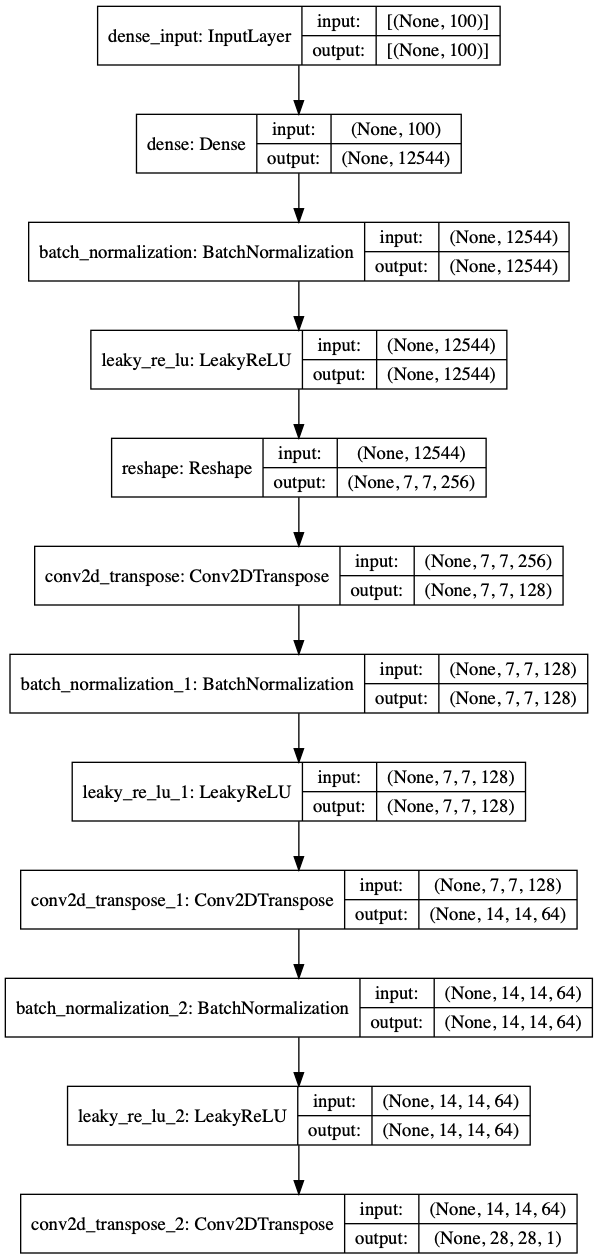

In [11]:
tf.keras.utils.plot_model(gen, show_shapes=True)

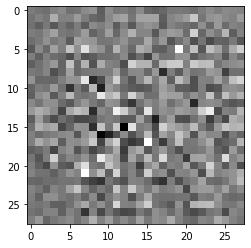

In [12]:
generator = make_generator_model()

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')

## Discriminator Model

In [13]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

In [14]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[0.00468918]], shape=(1, 1), dtype=float32)


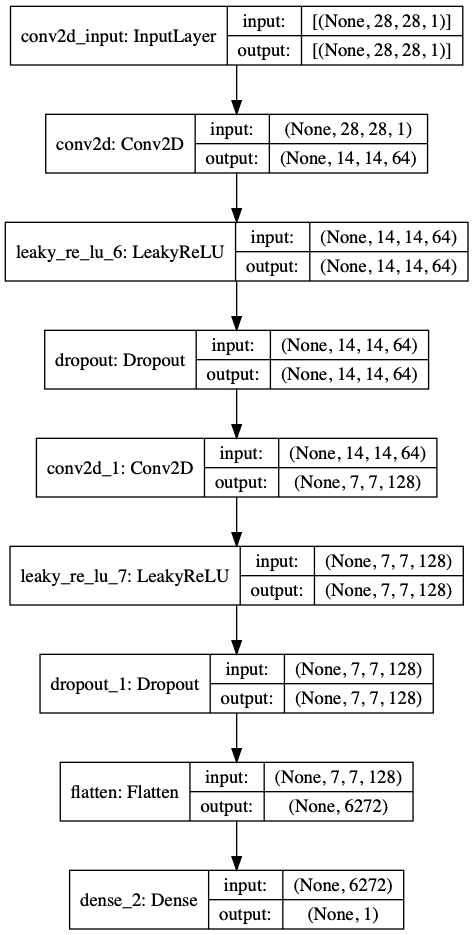

In [15]:
tf.keras.utils.plot_model(discriminator, show_shapes=True)

## Loss Functions

In [16]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [17]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [18]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [19]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [20]:
EPOCHS = 50
noise_dim = 100
num_examples_to_generate = 16

# You will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

## Training Custom Loop 

The training of the GAN works as explained in the diagram

![GAN Training](images/GAN_Training_Schema.png)

Step A and B are repeated in sequence.


In [21]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      # Calculation of X_{fake}
      generated_images = generator(noise, training=True)

      # Calculation of \hat Y_{real}
      real_output = discriminator(images, training=True)
    
      # Calculation of \hat Y_{fake}
      fake_output = discriminator(generated_images, training=True)

      # Calculation of L_G
      gen_loss = generator_loss(fake_output)
    
      # Calculation of L_D
      disc_loss = discriminator_loss(real_output, fake_output)

    #
    # Gradients Calculation
    #
    # Calculation of the gradients of L_G for backpropagation
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    
    # Calculation of the gradients of L_D for backpropagation
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    #
    # Training Steps A and B
    #
    # Step A
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))

    # Step B
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [22]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [23]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)

    # Produce images for the GIF as you go
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)

    # Save the model every 15 epochs
    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed)

In [25]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4, 4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

## Training of the GAN

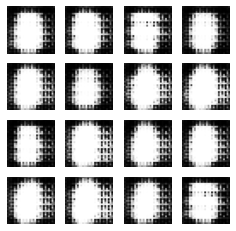

Time for epoch 2 is 101.33213996887207 sec


KeyboardInterrupt: 

In [26]:
EPOCHS = 50
train(train_dataset, EPOCHS)

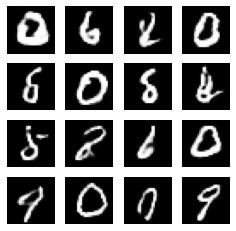

In [23]:
EPOCHS = 200
train(train_dataset, EPOCHS)

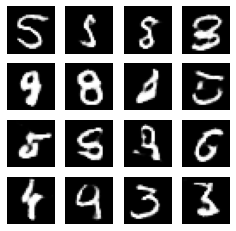

In [28]:
# This code generates each time new digits
seed2 = tf.random.normal([num_examples_to_generate, noise_dim])
generate_and_save_images(generator,
                           10,
                           seed2)

## Tests: Single Images

Let's see single images

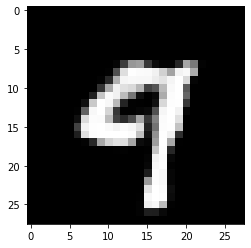

In [40]:
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')

# References

[1] Radford, Alec, Luke Metz, and Soumith Chintala. "Unsupervised representation learning with deep convolutional generative adversarial networks." arXiv preprint [arXiv:1511.06434](https://arxiv.org/pdf/1511.06434.pdf%C3) (2015).